##DATSCIW261 ASSIGNMENT #5

MIDS UC Berkeley, Machine Learning at Scale

DATSCIW261 ASSIGNMENT #5

TEAM 4: Hetal Chandaria (hetalchandaria@berkeley.edu), Marjorie Sayer (3marjorie14@gmail.com), Patrick Ng (patng323@gmail.com)

Version 2016-02-19 (FINAL)


In [279]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###HW 5.0

**What is a data warehouse?** 

A data warehouse is a central repository of integrated data used for reporting and analysis purposes. Typically the data is loaded into the warehouse from disparate sources, and the data undergoes preliminary processing to make it report-ready or analysis-ready. This process is referred to as "ETL" - Extract, Transform, and Load. 

An example of a data warehouse for a large company might be: data from sales, manufacturing, R&D, service, finance are all stored in the warehouse. The transform process might normalize data, one-hot encode data, and so on. 

**What is a Star schema? When is it used?**

A Star Schema is a star-shaped denormalized database schema that consists of two types of tables: Fact tables and Dimension tables. Fact tables contain measurable, quantitative data and Dimension tables contain descriptive data. For example, a fact table for a toy store would contain units made on particular dates, units sold on dates, where units are distributed. Corresponding dimension tables would contain toy models, colors, sizes, and other characteristics of the toys. 

Typically Dimension tables have fewer records but more attributes than Fact tables. Fact tables lie in the center of the Star Schema, with associated Dimension tables branching out from the central Fact tables. 

Star Schemas are useful in cases where certain queries about transactions are made frequently. For example, suppose a business sells Products in a collection of Stores. There would be many queries of a particular type such as how many products sold in certain periods; how many sold by location. It would make sense to build a Star Schema with transactions as the Fact table, and Dimension tables such as Date, Store, and Product. The Dimension tables would be small but hold all particulars about each dimension. 

In a MapReduce context, Dimension Tables could be held in memory or read into a hash table and the far larger Fact table used for streaming input. 

If relationships become too complex, a Star Schema might not be as useful. Star Schemas, since they are not normalized, have a risk of becoming inconsistent. 

###HW 5.1

**In the database world What is 3NF?** 
3NF stands for third normal form. A set of database tables is normalized if redundant information is removed. This aids in database consistency and accuracy; if values are repeated, they can get out of sync. There are several levels of normalization. 
First normal form: a table is in first normal form if and only if the domain of each attribute contains only atomic (indivisible) values, and the value of each attribute contains only a single value from that domain.

Second normal form: a table is in second normal form if it is in first normal form and no non-prime attribute is dependent on any proper subset of any candidate key of the table. A non-prime attribute of a table is an attribute that is not a part of any candidate key of the table. (A candidate key uniquely defines rows in the table). 

A table R is in 3NF if the following two conditions hold: 

- The relation R (table) is in second normal form (2NF)
- Every non-prime attribute of R is non-transitively dependent on every key of R.

3NF is a more rigorous normalization condition than first or second normal form. 

**Does machine learning use data in 3NF? If so why?**
Machine learning learns from samples. The samples have characteristics that a model can learn. For machine learning it is best to represent data with all of its characteristics present. In 3NF, information can be spread out in different tables. 

**In what form does ML consume data?**
ML consumes data as samples with collections of features. 

**Why would one use log files that are denormalized?**
To assemble all the features that could influence a model together. 

### HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)
:

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

(1) Left joining Table Left with Table Right

(2) Right joining Table Left with Table Right

(3) Inner joining Table Left with Table Right

<span style="color: blue"> Answer: </span>

left table = url table of the format page id, url (294 entries)

right table = log table of the format V,page id, C, customer id (98,654 entries)
 

The left table is chosen to be the smaller table, because in memory backed map-side joins the left table is the one held in memory.


In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
%%writefile MRJoin_5_2.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

class MRJoin(MRJob):
    urls = {} # key = pageId, value = url
    keys_emitted = set() # Set of keys of all emitted urls. Used for left join.
    
    def configure_options(self):
        super(MRJoin, self).configure_options()
        self.add_passthrough_option(
            '--joinType', type='str', default="inner")
        
    def load_options(self, args):
        super(MRJoin, self).load_options(args)
        self.joinType = self.options.joinType
        
    def mapper_init(self):
        # Load URL info data file into memory.  
        # Line format: 
        # 1287,/autoroute
        with open("hw52input.txt", "r") as f:
            for fields in csv.reader(f):
                self.urls[fields[0]] = fields[1]

    def mapper(self, line_no, line):
        # Line format: 
        # V,1000,1,C,10001
        fields = csv.reader([line]).next()
        
        key = fields[1]
        url = None
        toEmit = False
        
        if key in self.urls:
            url = self.urls[key]
            
        if self.joinType == "right":
            toEmit = True
        elif self.joinType == "left":
            if url is not None:
                toEmit = True
                self.keys_emitted.add(key) # Remember what we have emitted
        else: # inner join
            if url is not None:
                toEmit = True
        
        if toEmit:
            # Output format
            # pageid, url,V,1,C,10001
            yield key, (url, fields[0], fields[2], fields[3], fields[4])
        
    def mapper_final(self):
        if self.joinType == "left":
            # Emit all the remaining urls
            remaining = set(self.urls.keys()) - self.keys_emitted
            for key in remaining:
                yield key, (self.urls[key], None, None, None, None)
                                
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final)
            ]
    
if __name__ == '__main__':
    MRJoin.run()

Overwriting MRJoin_5_2.py


In [8]:
from MRJoin_5_2 import MRJoin

print "HW5.2 Summary Results\n"

for joinType in ["left", "right", "inner"]:
    mr_job = MRJoin(args=['hw42output.txt', 
                        '--file', 'hw52input.txt', # broadcast to every mapper
                        "--strict-protocols",
                        '--joinType', joinType])

    with mr_job.make_runner() as runner: 
        runner.run()

        lines = []
        for line in runner.stream_output():
            lines.append(line)
            
        print "Join type:" + joinType
        print "Number of records:" + str(len(lines))
        print "First 5 lines:"
        for i in range(5):
            print lines[i].strip()
            
        print

HW5.2 Summary Results

Join type:left
Number of records:98663
First 5 lines:
"1000"	["www.microsoft.com/regwiz", "V", "1", "C", " 10001"]
"1001"	["www.microsoft.com/support", "V", "1", "C", " 10001"]
"1002"	["www.microsoft.com/athome", "V", "1", "C", " 10001"]
"1001"	["www.microsoft.com/support", "V", "1", "C", " 10002"]
"1003"	["www.microsoft.com/kb", "V", "1", "C", " 10002"]

Join type:right
Number of records:98654
First 5 lines:
"1000"	["www.microsoft.com/regwiz", "V", "1", "C", " 10001"]
"1001"	["www.microsoft.com/support", "V", "1", "C", " 10001"]
"1002"	["www.microsoft.com/athome", "V", "1", "C", " 10001"]
"1001"	["www.microsoft.com/support", "V", "1", "C", " 10002"]
"1003"	["www.microsoft.com/kb", "V", "1", "C", " 10002"]

Join type:inner
Number of records:98654
First 5 lines:
"1000"	["www.microsoft.com/regwiz", "V", "1", "C", " 10001"]
"1001"	["www.microsoft.com/support", "V", "1", "C", " 10001"]
"1002"	["www.microsoft.com/athome", "V", "1", "C", " 10001"]
"1001"	["www.microsof

#### HW 5.3 

HW 5.3  EDA of Google n-grams dataset
For the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

googlebooks-eng-all-5gram-20090715-0-filtered.txt

Finally show your results on the Google n-grams dataset. 


In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

HW 5.3.1 OPTIONAL Question:
- Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
https://en.wikipedia.org/wiki/Log%E2%80%93log_plot

https://en.wikipedia.org/wiki/Power_law

#### Longest 5-gram (number of characters)

In [287]:
%%writefile longestngram.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import csv, re
from mrjob.protocol import RawProtocol, ReprProtocol

class Longest(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper, combiner = self.combiner, reducer = self.reducer)
               ]
    
    def mapper(self, line_no, line):
        ngram,occurence,page_count,book_count = line.strip().split('\t')
        yield None,(len(ngram),ngram)
        
    def combiner(self,_,value):
        yield None, (max(value))
        
    def reducer(self,_,value):
        yield max(value)
                          
if __name__ == '__main__':
    Longest.run()

Overwriting longestngram.py


In [288]:
%load_ext autoreload
%autoreload 2
from longestngram import Longest
import csv

mr_job = Longest(args=['filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    print "Longest 5-gram is "
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Longest 5-gram is 
(58, 'Interpersonal Communication Interpersonal communication is')


In [257]:
from longestngram import Longest

mr_job = Longest(args=['s3://filtered-5grams/', '-r', 'emr', '--no-output'])

with mr_job.make_runner() as runner: 
    runner.run()
    print "Longest 5-gram is "
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)    

Longest 5-gram is 
(159, 'ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT')


#### Top 10 most frequent words (count), i.e., unigrams

In [289]:
%%writefile frequentwords.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import csv, re
from mrjob.protocol import RawProtocol, ReprProtocol

WORD_RE = re.compile(r"[\w']+")

class FrequentWords(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper, combiner = self.combiner, reducer = self.reducer)
               ]
    
    def mapper(self, line_no, line):
        ngram,occurence,page_count,book_count = line.strip().split('\t')
        words = re.findall(WORD_RE,ngram)
        for word in words:
            yield word.lower(),int(occurence)
        
    def combiner(self,word,value):
        yield word, sum(value)
        
    def reducer(self, word ,value):
        yield word, sum(value)
                          
if __name__ == '__main__':
    FrequentWords.run()

Overwriting frequentwords.py


In [263]:
!python ./frequentwords.py  filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt -q >words.out

In [264]:
!sort -k2 -n -r words.out > top10.out
! head -10 top10.out

"the"	27691943
"of"	18590950
"to"	11601757
"in"	7470912
"a"	6926743
"and"	6150529
"that"	4077421
"is"	4074864
"be"	3720812
"was"	2492074


In [269]:
!python ./frequentwords.py \
    -r emr s3://filtered-5grams \
    --output-dir=s3://hvcemrbucket/output/hw5/topfrequent \
    --no-output \
    --no-strict-protocol

Got unexpected keyword arguments: ssh_tunnel
using configs in /Users/hetal/.mrjob.conf
using existing scratch bucket mrjob-effea262003c6b3a
using s3://mrjob-effea262003c6b3a/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/frequentwords.hetal.20160215.024543.071579
writing master bootstrap script to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/frequentwords.hetal.20160215.024543.071579/b.py
Copying non-input files into s3://mrjob-effea262003c6b3a/tmp/frequentwords.hetal.20160215.024543.071579/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-K0ZK6SXTK7C0
Created new job flow j-K0ZK6SXTK7C0
Job launched 30.8s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.6s ago, status STARTING: Provisioning Amazon 

In [276]:
!rm -fR output/topfrequent
!mkdir -p ./output/topfrequent
!aws s3 cp --recursive s3://hvcemrbucket/output/hw5/topfrequent ./output/topfrequent
# !cat ./output/topfrequent/part* | sort -k2 -n -r | head -10000 > ./output/top10frequenct.txt
# !rm -fR output/topfrequent

download: s3://hvcemrbucket/output/hw5/topfrequent/_SUCCESS to output/topfrequent/_SUCCESS
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00007 to output/topfrequent/part-00007
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00006 to output/topfrequent/part-00006
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00000 to output/topfrequent/part-00000
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00003 to output/topfrequent/part-00003
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00004 to output/topfrequent/part-00004
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00009 to output/topfrequent/part-00009
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00005 to output/topfrequent/part-00005
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00001 to output/topfrequent/part-00001
download: s3://hvcemrbucket/output/hw5/topfrequent/part-00010 to output/topfrequent/part-00010
download: s3://hvcemrbucket/output/hw5/topfrequent/par

In [297]:
!cat ./output/topfrequent/part* | sort -k2nr  > ./output/topwords.txt
!rm -fR output/topfrequent
!head -10 ./output/topwords.txt

"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314


##### Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency (Hint: save to PART-000* and take the head -n 1000)

In [290]:
%%writefile density.py

from mrjob.job import MRJob
from mrjob.step import MRJobStep
import csv, re
from mrjob.protocol import RawProtocol, ReprProtocol

WORD_RE = re.compile(r"[\w']+")

class DensityWords(MRJob):
    def steps(self):
        return [
            MRJobStep(mapper=self.mapper, combiner = self.combiner, reducer = self.reducer)
               ]
    
    def mapper(self, line_no, line):
        ngram,occurence,page_count,book_count = line.strip().split('\t')
        words = re.findall(WORD_RE,ngram)
        for word in words:
            yield word.lower(),(occurence,page_count)
        
    def combiner(self,word,value):
        count =0
        pagecount = 0
        for cnt, pagecnt in value:
            count += int(cnt)
            pagecount += int(pagecnt)
        yield word, (count,pagecount)
        
    def reducer(self, word ,value):
        count =0
        pagecount = 0
        for cnt, pagecnt in value:
            count += int(cnt)
            pagecount += int(pagecnt)
        yield word, (1.0*count/pagecount)
                          
if __name__ == '__main__':
    DensityWords.run()

Overwriting density.py


In [291]:
!python ./density.py  filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt  -q > density.out

In [292]:
!sort -k2 -n -r density.out > density_sorted.out
print 'Most Densely appearing word '
! head -10 density_sorted.out
print '\nLeast densely appearing word'
! tail -10 density_sorted.out

Most Densely appearing word 
"lak"	3.072289156626506
"operand"	2.353448275862069
"bust"	2.3493975903614457
"houseless"	2.274891774891775
"gynecological"	2.2481536189069424
"denatured"	2.1864406779661016
"expiration"	2.1568513119533526
"phe"	2.0408163265306123
"kiowa"	2.0
"apiece"	1.9607843137254901

Least densely appearing word
"abateth"	1.0
"abatement"	1.0
"abated"	1.0
"abate"	1.0
"abased"	1.0
"abandons"	1.0
"abandoning"	1.0
"aback"	1.0
"aalborg"	1.0
"aahperd"	1.0


In [293]:
#running job on EMR
!python ./density.py \
    -r emr s3://filtered-5grams \
    --output-dir=s3://hvcemrbucket/output/hw5/density \
    --no-output \
    --no-strict-protocol -q

In [365]:
!rm -fR output/density
!mkdir -p ./output/density
!aws s3 cp --recursive s3://hvcemrbucket/output/hw5/density ./output/density

download: s3://hvcemrbucket/output/hw5/density/_SUCCESS to output/density/_SUCCESS
download: s3://hvcemrbucket/output/hw5/density/part-00002 to output/density/part-00002
download: s3://hvcemrbucket/output/hw5/density/part-00001 to output/density/part-00001
download: s3://hvcemrbucket/output/hw5/density/part-00004 to output/density/part-00004
download: s3://hvcemrbucket/output/hw5/density/part-00006 to output/density/part-00006
download: s3://hvcemrbucket/output/hw5/density/part-00003 to output/density/part-00003
download: s3://hvcemrbucket/output/hw5/density/part-00005 to output/density/part-00005
download: s3://hvcemrbucket/output/hw5/density/part-00000 to output/density/part-00000


In [366]:
!rm ./output/density_emr.out
!cat ./output/density/part* | sort -k2nr  > ./output/density_emr.out
!rm -fR output/density
print "Most dense words"
!head -10 ./output/density_emr.out
print "\n Least dense words"
!tail -10 ./output/density_emr.out

Most dense words
"xxxx"	11.557291666666666
"blah"	8.0741599073001158
"nnn"	7.5333333333333332
"na"	6.2017491314244637
"oooooooooooooooo"	4.921875
"nd"	4.8543057272352703
"llll"	4.5116279069767442
"oooooo"	4.169650013358269
"ooooo"	3.8586371934672128
"lillelu"	3.7624521072796937

 Least dense words
"zygmunt"	1.0
"zygomaticofacial"	1.0
"zygomaticotemporal"	1.0
"zygosity"	1.0
"zylindrischen"	1.0
"zymelman"	1.0
"zymogens"	1.0
"zymophore"	1.0
"zymosan"	1.0
"zymosis"	1.0


<span style="color: blue"> Distribution of 5-gram sizes (character length). E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.</span>

In [296]:
%%writefile ngram_distribution.py

from mrjob.job import MRJob
from mrjob.step import MRJobStep
import csv, re
from mrjob.protocol import RawProtocol, ReprProtocol

WORD_RE = re.compile(r"[\w']+")

class LengthDistribution(MRJob):
    count = 0
    reducer_total = 0
    def steps(self):
        return [
            MRJobStep(mapper=self.mapper, combiner = self.combiner, reducer = self.reducer)
               ]
    
    def mapper(self, line_no, line):
        ngram,occurence,page_count,book_count = line.strip().split('\t')
        yield len(ngram),1
        
    def combiner(self,key,value):
        yield key, sum(value)
        
    def reducer(self, key ,value):
        yield key,sum(value)
                          
if __name__ == '__main__':
    LengthDistribution.run()

Overwriting ngram_distribution.py


In [368]:
!python ./ngram_distribution.py  filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt  -q 

10	1
11	1
12	3
13	22
14	94
15	309
16	1112
17	2859
18	5853
19	10200
20	15479
21	20108
22	24625
23	27333
24	28052
25	27690
26	25991
27	23405
28	20587
29	17257
30	14428
31	11340
32	9061
33	6950
34	5152
35	3871
36	2868
37	2027
38	1516
39	1027
40	756
41	476
42	337
43	263
44	195
45	113
46	87
47	51
48	33
49	31
50	13
51	10
52	9
53	8
54	2
55	4
57	2
58	2
9	1


In [369]:
!python ./ngram_distribution.py \
-r emr s3://filtered-5grams \
    --output-dir=s3://hvcemrbucket/output/hw5/distribution \
    --no-output \
    --no-strict-protocol -q

In [137]:
#get top 1000 closest pairs from jaccard similarity
!rm -fR output/distribution
!mkdir -p ./output/distribution
!aws s3 cp --recursive s3://hvcemrbucket/output/hw5/distribution ./output/distribution
!rm ./output/distribution_all.out
!cat ./output/distribution/part*   > ./output/distribution_all.out
!rm -fR output/distribution

download: s3://hvcemrbucket/output/hw5/distribution/_SUCCESS to output/distribution/_SUCCESS
download: s3://hvcemrbucket/output/hw5/distribution/part-00006 to output/distribution/part-00006
download: s3://hvcemrbucket/output/hw5/distribution/part-00001 to output/distribution/part-00001
download: s3://hvcemrbucket/output/hw5/distribution/part-00000 to output/distribution/part-00000
download: s3://hvcemrbucket/output/hw5/distribution/part-00003 to output/distribution/part-00003
download: s3://hvcemrbucket/output/hw5/distribution/part-00004 to output/distribution/part-00004
download: s3://hvcemrbucket/output/hw5/distribution/part-00005 to output/distribution/part-00005
download: s3://hvcemrbucket/output/hw5/distribution/part-00002 to output/distribution/part-00002
rm: ./output/distribution_all.out: No such file or directory


In [139]:
%matplotlib inline

/Users/hetal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


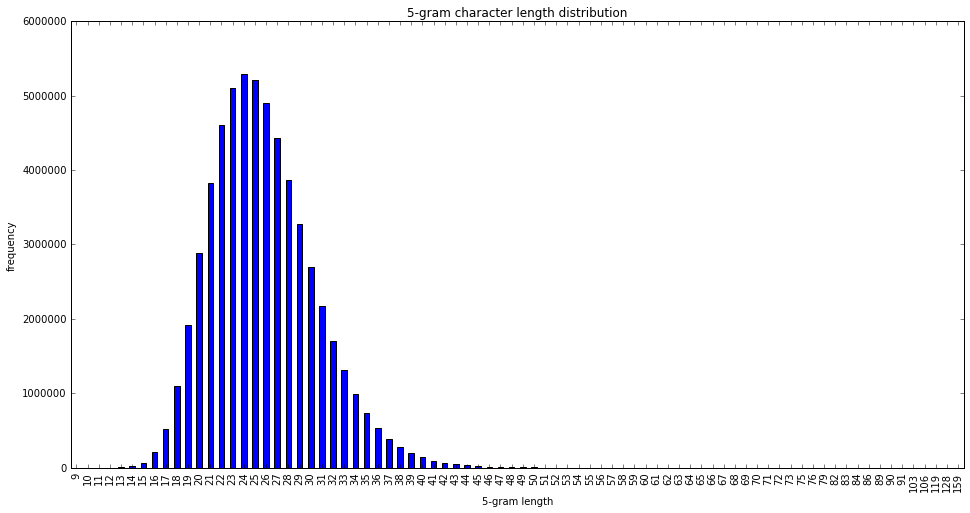

In [156]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 16, 8  # plotsize 

df = pd.read_csv('./output/distribution_all.out',sep='\t',header=None)
df.columns = ['length','frequency']
df = df.sort('length')
df = df.set_index('length')
my_plot = df.plot(kind='bar',legend=None,title="5-gram character length distribution")
my_plot.set_xlabel("5-gram length")
my_plot.set_ylabel("frequency")


#### HW 5.4  (over 2Gig of Data)
In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes of word co-ocurrence for the top 10,000 using the words ranked from 9001,-10,000 as a basis
most frequently appearing words across the entire set of 5-grams,
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation
...

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

In [302]:
! rm topwords_touse.out
!cat ./output/topwords.txt | sed -n 9001,10000p > topwords_touse.out
!aws s3 cp topwords_touse.out s3://hvcemrbucket/input/hw5/

upload: ./topwords_touse.out to s3://hvcemrbucket/input/hw5/topwords_touse.out


In [354]:
%%writefile stripes.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import csv, re, string
import urllib2
from mrjob.protocol import RawProtocol, ReprProtocol

WORD_RE = re.compile(r"[\w']+")

class Stripes(MRJob):
    topwords={}
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init, mapper=self.mapper, combiner= self.combiner, reducer=self.reducer)
               ]
    
    def mapper_init(self):
        top_words = 'https://s3-us-west-1.amazonaws.com/hvcemrbucket/input/hw5/topwords_touse.out'
        a = urllib2.urlopen(top_words)
        data= a.read().strip().split('\n')
        top_touse=[]
        for row in data:
            key = row.strip().split('\t')
            top_touse.append(key[0].replace('"',''))
        self.topwords=set(top_touse) 
#         with open('topwords.out') as f:
#             self.topwords = {k for line in f for (k, v) in (line.replace('"', '').strip().split('\t'),)}
    
    def mapper(self, line_no, line):
        words_stripe={}
        ngram,occurence,page_count,book_count = line.strip().split('\t')
        ngram_strip =ngram.translate(None, string.punctuation)
        words = re.findall(WORD_RE,ngram_strip.lower())
        for term in words:
            if term not in self.topwords:
                continue
            if term not in words_stripe:
                words_stripe[term]={}  
            for word in words:
                if word in self.topwords and term != word:
                    if word not in words_stripe[term]:
                        words_stripe[term][word] = int(occurence)
                    else:
                        words_stripe[term][word] += int(occurence)
        for term, neighbors in words_stripe.iteritems():
            if len(neighbors) != 0:
                yield term, neighbors
    
       
    def combiner(self,term,neighbors):
        words_stripe ={}
        words_stripe[term]={}
        for v in neighbors:
            for key in v:
                if key not in words_stripe[term]:
                    words_stripe[term][key] = v[key]
                else :
                    words_stripe[term][key] += v[key]
        for term, neighbors in words_stripe.iteritems():
            yield term, neighbors
    
    def reducer(self,term,neighbors):
        words_stripe ={}
        for v in neighbors:
            for key in v:
                if key not in words_stripe:
                    words_stripe[key] = 0
                words_stripe[key] += v[key]
        yield term, words_stripe
                   
if __name__ == '__main__':
    Stripes.run()

Overwriting stripes.py


In [357]:
!python ./stripes.py  filtered-5Grams/googlebooks-eng-all-5gram-20090715-0-filtered.txt -q

"alternate"	{"viewing": 82}
"amidst"	{"tumult": 80, "restless": 43}
"ammonium"	{"hydroxide": 78}
"anemia"	{"pernicious": 58}
"annum"	{"thereon": 69}
"approximated"	{"subcutaneous": 120}
"architectural"	{"decoration": 46}
"articular"	{"cartilage": 51}
"authoritative"	{"interpreter": 50}
"balcony"	{"overlooking": 139}
"bottles"	{"necks": 65}
"brightest"	{"diamond": 71}
"canons"	{"commonest": 43}
"careless"	{"hasty": 58}
"cartilage"	{"articular": 51, "localized": 51}
"ce"	{"qui": 48}
"commence"	{"qui": 63, "palestinian": 62}
"commonest"	{"canons": 43}
"commonplace"	{"feathers": 84}
"complexion"	{"darker": 86}
"contradictory"	{"predicate": 171}
"conveying"	{"pipes": 155}
"dame"	{"habitation": 66}
"darker"	{"complexion": 86}
"darkest"	{"superstition": 110}
"decoration"	{"architectural": 46}
"deliberations"	{"trent": 47}
"diamond"	{"brightest": 71}
"discomfort"	{"localized": 43}
"dividend"	{"shareholders": 43}
"dumb"	{"pretending": 69}
"endowment"	{"unstable": 84}
"est"	{"qui": 83}
"establis

In [356]:
!python ./stripes.py  \
-r emr s3://filtered-5grams \
--output-dir=s3://hvcemrbucket/output/hw5/stripes \
--no-output \
--no-strict-protocol 

Got unexpected keyword arguments: ssh_tunnel
using configs in /Users/hetal/.mrjob.conf
creating new scratch bucket mrjob-f7f5fce3ffcc49a1
using s3://mrjob-f7f5fce3ffcc49a1/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/stripes.hetal.20160215.075055.806501
writing master bootstrap script to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/stripes.hetal.20160215.075055.806501/b.py
creating S3 bucket 'mrjob-f7f5fce3ffcc49a1' to use as scratch space
Copying non-input files into s3://mrjob-f7f5fce3ffcc49a1/tmp/stripes.hetal.20160215.075055.806501/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-2WCZ4WQW9O9BP
Created new job flow j-2WCZ4WQW9O9BP
Job launched 30.8s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched

In [6]:
%%writefile jaccard.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import csv, re, string
from mrjob.protocol import RawProtocol, ReprProtocol

WORD_RE = re.compile(r"[\w']+")

class Jaccard(MRJob):
    global_doc_dict = {}
    def steps(self):
        return [
            MRStep(mapper=self.mapper , reducer= self.reducer, 
                   jobconf={
                    "mapred.map.tasks":16,
                    "mapred.reduce.tasks":8
                    }),
            MRStep(mapper=self.mapper2 ,combiner=self.combiner2, reducer=self.reducer2,
                   jobconf={
                    "mapred.map.tasks":8,
                    "mapred.reduce.tasks":4
                    }
                  ),
             MRStep(reducer=self.jaccard_cal, 
                    jobconf={
                    "mapred.map.tasks":4,
                    "mapred.reduce.tasks":1
                    })
            
               ]
    
    def mapper(self, _, line):
        key,terms = line.strip().split('\t')
        docs = eval(terms).keys()
        for doc in docs:
            yield doc,key.replace('"', '')
    
    def reducer(self,key,value):
        doc_list ={}
        for v in value:
            doc_list[v]=1
        yield key, doc_list.keys()
        
    def mapper2(self,key,value):
        doc_list = list(value)
        for i in range(0,len(doc_list)):
            starkey = '*' + doc_list[i]
            yield (starkey, doc_list[i]),1
            for j in range(i+1, len(doc_list)):
                yield(doc_list[i],doc_list[j]),1
    
    def combiner2(self,key,value):
        yield key,sum(value)
    
    def reducer2(self,key,value):
        yield key,sum(value)
    
    def jaccard_cal(self,key,value):
        docA,docB = key

        if docA.startswith('*'): #|doc|
            self.global_doc_dict[docB] = sum(value)
        else:  #at this point we have all the |doc|
            ab = sum(value)
            calc = 1.0*ab / (self.global_doc_dict[docA] + self.global_doc_dict[docB] - ab)
            yield (docA,docB), calc
 
                   
if __name__ == '__main__':
    Jaccard.run()

Overwriting jaccard.py


In [13]:
!python ./jaccard.py -r hadoop inv_index.out -q >jaccard_similarity.out

In [8]:
!python ./jaccard.py  \
-r emr s3://hvcemrbucket/output/hw5/stripes/ \
--output-dir=s3://hvcemrbucket/output/hw5/jaccard \
--no-output \
--no-strict-protocol 


Got unexpected keyword arguments: ssh_tunnel
using configs in /Users/hetal/.mrjob.conf
using existing scratch bucket mrjob-f7f5fce3ffcc49a1
using s3://mrjob-f7f5fce3ffcc49a1/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/jaccard.hetal.20160215.174037.268622
writing master bootstrap script to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/jaccard.hetal.20160215.174037.268622/b.py
Copying non-input files into s3://mrjob-f7f5fce3ffcc49a1/tmp/jaccard.hetal.20160215.174037.268622/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-PNXRGWIBHK15
Created new job flow j-PNXRGWIBHK15
Job launched 30.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job l

In [9]:
%%writefile cosine_similarity.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import csv, re, string, math
from mrjob.protocol import RawProtocol, ReprProtocol

WORD_RE = re.compile(r"[\w']+")

class Cosine(MRJob):
    global_doc_dict = {}
    def steps(self):
        return [
            MRStep(mapper=self.mapper, reducer= self.reducer,jobconf={
                    "mapred.map.tasks":16,
                    "mapred.reduce.tasks":8
                    }
                  ),
            MRStep(mapper=self.mapper2 ,combiner=self.combiner2, reducer=self.reducer2,
                   jobconf={
                    "mapred.map.tasks":8,
                    "mapred.reduce.tasks":4
                    }
                  )
               ]
    
    def mapper(self, _, line):
        total_sqrt = 0
        total_sq_cnt= 0 
        key,terms = line.strip().split('\t')
        docs = eval(terms)
        #normalise the counts for cosine similarity
        for word, count in docs.iteritems():
            total_sq_cnt += count**2
        total_sqrt = math.sqrt(total_sq_cnt)
        for doc,count in docs.iteritems():
            yield doc,(key.replace('"', ''), 1.0*count/total_sqrt)
    
    def reducer(self,key,value):
        doc_list ={}
        for doc,dist in value:
            doc_list[doc]=dist
        yield key, doc_list
        
    def mapper2(self,key,value):
        keys = value.keys()
        for key1 in keys:
            for key2 in keys:
                if(key1 == key2):
                    continue
                multiplied_keys = value[key1]*value[key2]
                yield(key1,key2),multiplied_keys
    
    def combiner2(self,key,value):
        yield key,sum(value)
    
    def reducer2(self,key,value):
        yield key,sum(value)
    
                   
if __name__ == '__main__':
    Cosine.run()

Overwriting cosine_similarity.py


In [17]:
!python ./cosine_similarity.py -r hadoop inv_index.out -q >cosine_similarity.out

In [12]:
!python ./cosine_similarity.py  \
-r emr s3://hvcemrbucket/output/hw5/stripes/ \
--output-dir=s3://hvcemrbucket/output/hw5/cosine_similarity \
--no-output \
--no-strict-protocol 

Got unexpected keyword arguments: ssh_tunnel
using configs in /Users/hetal/.mrjob.conf
using existing scratch bucket mrjob-f7f5fce3ffcc49a1
using s3://mrjob-f7f5fce3ffcc49a1/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/cosine_similarity.hetal.20160215.180250.904567
writing master bootstrap script to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/cosine_similarity.hetal.20160215.180250.904567/b.py
Copying non-input files into s3://mrjob-f7f5fce3ffcc49a1/tmp/cosine_similarity.hetal.20160215.180250.904567/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-KKUIS43HB212
Created new job flow j-KKUIS43HB212
Job launched 30.8s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.6s ago, status STARTING: Provisio

#### HW 5.5 Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector.
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in (2), and use the synonyms function in the accompanying
python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.




In [36]:
#get top 1000 closest pairs from jaccard similarity
!rm -fR output/jaccard_similarity
!mkdir -p ./output/jaccard_similarity
!aws s3 cp --recursive s3://hvcemrbucket/output/hw5/jaccard ./output/jaccard_similarity
!rm ./output/jaccard_similarity_all.out
!cat ./output/jaccard_similarity/part* | sort -k3nr  > ./output/jaccard_similarity_all.out
!rm -fR output/jaccard_similarity

download: s3://hvcemrbucket/output/hw5/jaccard/_SUCCESS to output/jaccard_similarity/_SUCCESS
download: s3://hvcemrbucket/output/hw5/jaccard/part-00000 to output/jaccard_similarity/part-00000


In [37]:
#get top 1000 closest pairs from cosine similarity
# some of the putputs have
!rm -fR output/cosine_similarity
!mkdir -p ./output/cosine_similarity
!aws s3 cp --recursive s3://hvcemrbucket/output/hw5/cosine_similarity ./output/cosine_similarity
!rm ./output/cosine_similarity_all.out
!cat ./output/cosine_similarity/part* | sort -k3nr  > ./output/cosine_similarity_all.out
!rm -fR output/cosine_similarity

download: s3://hvcemrbucket/output/hw5/cosine_similarity/_SUCCESS to output/cosine_similarity/_SUCCESS
download: s3://hvcemrbucket/output/hw5/cosine_similarity/part-00002 to output/cosine_similarity/part-00002
download: s3://hvcemrbucket/output/hw5/cosine_similarity/part-00001 to output/cosine_similarity/part-00001
download: s3://hvcemrbucket/output/hw5/cosine_similarity/part-00003 to output/cosine_similarity/part-00003
download: s3://hvcemrbucket/output/hw5/cosine_similarity/part-00000 to output/cosine_similarity/part-00000
rm: ./output/cosine_similarity_all.out: No such file or directory


In [136]:
import nltk
from nltk.corpus import wordnet as wn
import sys

jaccard = './output/jaccard_similarity_all.out'
cosine = './output/cosine_similarity_all.out'



def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()


def evaluate(string):
    syn_data = []
    hits = 0
    miss = 0
    with open(string) as f:
        for line in f:
            key,terms = line.strip().split('\t')
            docs = eval(key)
            syn_data.append((docs[0],docs[1],float(terms)))
    # todo : implement topn using heap
    sorted_data= sorted(syn_data, key=lambda row: float(row[2]), reverse=True)
    sorted_syn = sorted_data[:1000]
    
    for data in sorted_syn:
        if (data[1] in synonyms(data[0])) and (data[0] in synonyms(data[1]) ):
            hits += 1
        else:
            miss += 1
    print "Number of hits: ",hits
    print 'Number of misses: ',miss
    
evaluate(cosine)

Number of hits:  4
Number of misses:  996
